In [155]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

In [156]:

city='Chicago-Sketch'
#city = 'Winnipeg'
#city = 'chicago-regional'

data_dir = 'TransportationNetworks/'+city+'/'
#city = 'ChicagoRegional'


In [157]:
mat = []
value=[]
row=[1]
with open(data_dir+city+'_trips.tntp') as f:
    i=0
    
    for line in f:
        if i>=5:
            if (line[0:6]=='Origin'):
                row.append(int(line.split()[1]))
                mat.append(value)
                value=[]
            else:
                for l in line.split(';')[:-1]:
                    r = l.split(':')
                    value.append( (int(r[0]) , float(r[1]) ) )

            
        i+=1
    mat.append(value)

In [158]:
len(mat)

388

In [159]:
volume=pd.DataFrame()
for i in range(len(row)):
    temp_df = pd.DataFrame(mat[i],columns=['destination','V'])
    temp_df['origin'] = row[i]
    volume=volume.append(temp_df)


In [160]:
volume = volume.reset_index(drop=True)
volume = volume[['origin','destination','V']]

In [161]:
def drop_volumes(volumes,threshold=10e-2,log=False):
    v = volumes.copy()
    v = v.loc[v['origin'] != v['destination']]
    v = v.loc[v['V'] > threshold]
    if log:
        print('Volume reduction', 100*round(1-v['V'].sum() / volumes['V'].sum(),3),'%')
        print('OD number reduction',round(100*(1-len(v)/len(volumes)),3),'%')
    # add volume on remaining OD such that the total volume is maintained.
    v['V']=v['V'] * (volumes['V'].sum() / v['V'].sum())
    return v

In [162]:
v = volume.copy()
#v = drop_volumes(v,threshold=6e-2,log=True)

In [163]:
len(v)

142890

In [164]:
# Importing the networks into a Pandas dataframe consists of a single line of code
# but we can also make sure all headers are lower case and without trailing spaces

if city=='Chicago':
    skip=8
else:
    skip=6
net = pd.read_csv(data_dir+city+'_net.tntp', skiprows=skip, sep='\t')

trimmed= [s.strip().lower() for s in net.columns]
net.columns = trimmed

# And drop the silly first andlast columns
net.drop(['~', ';'], axis=1, inplace=True)

In [165]:
net = net.rename(columns={'init_node':'a','term_node':'b','free_flow_time':'time','b':'alpha','power':'beta'})
net['a'] = 'rnode_'+net['a'].astype(str)
net['b'] = 'rnode_'+net['b'].astype(str)


In [166]:
zone_dict = {'rnode_'+str(r):'zone_'+str(r) for r in row}


In [167]:
net['a'] = net['a'].apply(lambda x: zone_dict.get(x,x))
net['b'] = net['b'].apply(lambda x: zone_dict.get(x,x))

In [168]:
road_links = net[~(net['a'].str.contains('zone') | net['b'].str.contains('zone'))]
zone_to_road = net[net['a'].str.contains('zone') | net['b'].str.contains('zone')]

In [169]:
road_links = road_links.reset_index(drop=True)

In [170]:
road_links.index = 'rlink_'+road_links.index.astype(str)
road_links.index.name='index'

In [171]:
road_links['limit']=1000

In [172]:
road_links['vdf']='limited_bpr'

In [173]:
#Toll: 0.1 minutes/cent Distance: 0.25 minutes/mile/


In [174]:
if city=='Winnipeg':
    road_links['penalty'] =0
elif city=='Barcelona':
    road_links['penalty'] =0
elif city == 'ChicagoRegional':
    road_links['penalty'] = road_links['toll']*100*0.1 + road_links['length']*0.25
elif city  == 'Chicago-Sketch':
    road_links['penalty'] = road_links['toll']*100*0.1 + road_links['length']*0.04
else: 
    stop

In [175]:
zone_to_road = zone_to_road.reset_index(drop=True)
zone_to_road['direction'] = 'access'
zone_to_road['vdf']='limited_bpr'

In [176]:
Vzone_dict = {r:'zone_'+str(r) for r in row}
v['origin'] = v['origin'].apply(lambda x: Vzone_dict.get(x))
v['destination'] = v['destination'].apply(lambda x: Vzone_dict.get(x))

In [177]:
from numba import jit
@jit(nopython=True)
def limited_bpr(mat,der=False):
    #columns in mat : 'alpha','beta','limit','flow','time','penalty','capacity'
    #der return the second derivative (for the find beta...)
    jam_time=[]
    for i in range(mat.shape[0]):
        alpha = mat[i,0]
        beta = mat[i,1]
        limit = mat[i,2]
        V = mat[i,3]
        t0 = mat[i,4]
        penalty = mat[i,5]
        Q = mat[i,6]
        res =  t0 * (1 + alpha*np.power(V/Q, beta))
        if res > t0*limit: # we plateau the curve at limit.
            if der == False:
                jam_time.append(t0*limit + penalty)
            else:
                jam_time.append(0)
                
        else:
            if der == False:
                jam_time.append(res + penalty)     
            else:
                der = (t0*alpha*beta/(Q**beta)) *np.power(V,beta-1)
                jam_time.append(der)
    return jam_time

@jit(nopython=True)
def free_flow(mat,der=False):
    #columns in mat : 'alpha','beta','limit','flow','time','penalty','capacity'
    #der return the derivative (for the find beta...)
    t0 = mat[:,4]
    penalty = mat[:,5]
    if der == False:
        return t0
    else:
        return t0*0



vdf ={'limited_bpr':limited_bpr,'free_flow':free_flow}


## Import Model

In [178]:
self =stepmodel.StepModel()

In [179]:
self.volumes = v
self.road_links = road_links

In [180]:
self.zone_to_road = zone_to_road

In [181]:
self.zones = [z[1] for z  in zone_dict.items()]

In [182]:
%%time
self.step_road_pathfinder(method='bfw',tolerance=0.000001,maxiters=100,vdf=vdf,volume_column='V',log=True,num_cores=4)

iteration | Phi |  Rel Gap (%)
0 0.3 60.421
1 0.2 37.381
2 0.2016 21.512
3 0.2125 8.569
4 0.3 3.351
5 0.7406 1.154
6 0.8 0.204
7 0.8 0.048
8 0.05 0.61
9 0.8 0.035
10 0.2563 0.103
11 0.0969 0.229
12 0.2703 0.061
13 0.1109 0.117
14 0.0938 0.103
15 0.1578 0.087
16 0.2828 0.066
17 0.4422 0.043
18 0.8 0.022
19 0.8 0.005
20 0.4391 0.002
21 0.1203 0.017
22 0.0188 0.027
23 0.0219 0.022
24 0.025 0.027
25 0.0312 0.024
26 0.0422 0.014
27 0.0375 0.016
28 0.0297 0.018
29 0.0297 0.013
30 0.0453 0.013
31 0.0906 0.016
32 0.1188 0.011
33 0.1625 0.009
34 0.2516 0.009
35 0.4406 0.006
36 0.6672 0.003
37 0.8 0.001
38 0.7875 0.0
39 0.2078 0.0
40 0.0719 0.0
41 0.0109 0.011
42 0.0109 0.004
43 0.0109 0.007
44 0.0094 0.006
45 0.0063 0.002
46 0.0156 0.005
47 0 -0.0
Wall time: 38.8 s


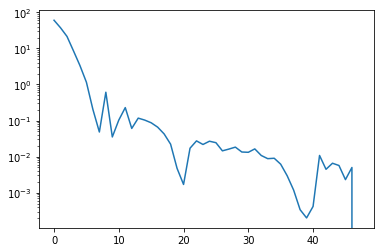

In [183]:
plt.semilogy(self.relgap)

In [184]:
net = pd.read_csv(data_dir+city+'_flow.tntp', skiprows=skip, sep='\t')


In [185]:
# Importing the networks into a Pandas dataframe consists of a single line of code
# but we can also make sure all headers are lower case and without trailing spaces
if city=='Winnipeg':
    skip=0
elif city=='Barcelona':
    skip=0
else:
    skip=0
net = pd.read_csv(data_dir+city+'_flow.tntp', skiprows=skip, sep='\t')

trimmed= [s.strip().lower() for s in net.columns]
net.columns = trimmed

# And drop the silly first andlast columns
#net.drop([';'], axis=1, inplace=True)

In [186]:
net = net.rename(columns = {'from':'a','to':'b'})
net['a'] = 'rnode_'+net['a'].astype(str)
net['b'] = 'rnode_'+net['b'].astype(str)


In [187]:
zone_dict = {'rnode_'+str(r):'zone_'+str(r) for r in row}

net['a'] = net['a'].apply(lambda x: zone_dict.get(x,x))
net['b'] = net['b'].apply(lambda x: zone_dict.get(x,x))

In [188]:
rlinks_dict = self.road_links.reset_index().set_index(['a','b'])['index'].to_dict()

In [189]:
net['index'] = net.set_index(['a','b']).index.map(rlinks_dict.get)

In [190]:
net = net[~net['index'].isna()]

In [191]:
net = net.set_index('index')

In [192]:
self.road_links['cost'] = self.road_links['jam_time']+self.road_links['penalty']

In [193]:
assert len(net) == len(self.road_links)

Text(0.5, 1.0, 'Chicago-Sketch')

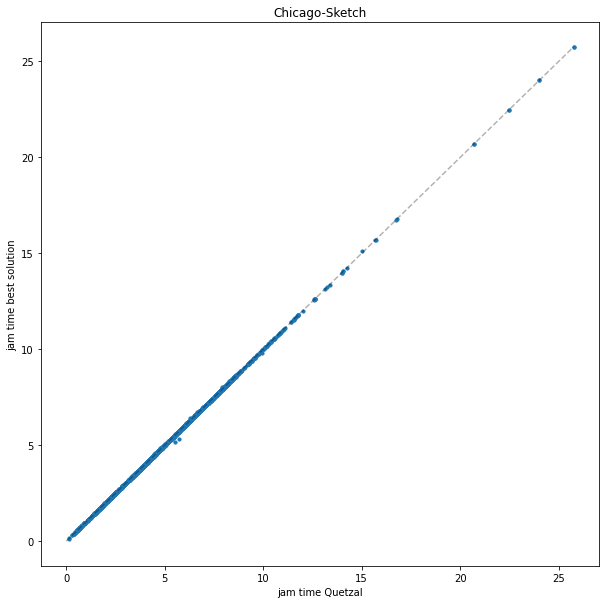

In [194]:
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(self.road_links['cost'],net['cost'],alpha=1,s=10)
maxvalue = self.road_links['cost'].max()
plt.plot([0,maxvalue],[0,maxvalue],'--k',alpha=0.3)

plt.xlabel('jam time Quetzal')
plt.ylabel('jam time best solution')
plt.title(city)

Text(0.5, 1.0, 'Chicago-Sketch')

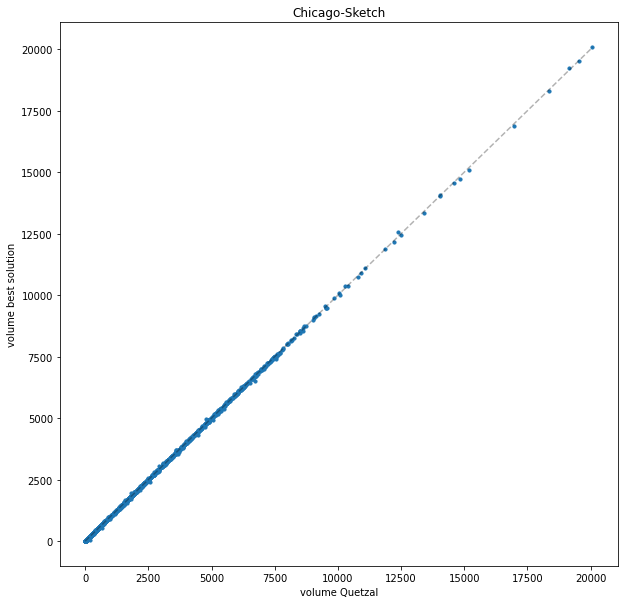

In [195]:
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(self.road_links['flow'],net['volume'],alpha=1,s=10)
maxvalue = self.road_links['flow'].max()
plt.plot([0,maxvalue],[0,maxvalue],'--k',alpha=0.3)
plt.xlabel('volume Quetzal')
plt.ylabel('volume best solution')
plt.title(city)

# objective function

In [196]:
print('quetzal', (self.road_links['flow']*self.road_links['cost']).sum())

quetzal 18847155.800228205


In [197]:
print('best solution', (net['volume']*net['cost']).sum())

best solution 18856947.744312614


In [198]:
print('diff=',100*(1-(self.road_links['flow']*self.road_links['cost']).sum()/(net['volume']*net['cost']).sum()), '%')

diff= 0.05192751349359925 %


In [199]:
self.road_links['volume_diff'] = self.road_links['flow'] - net['volume']

<AxesSubplot:>

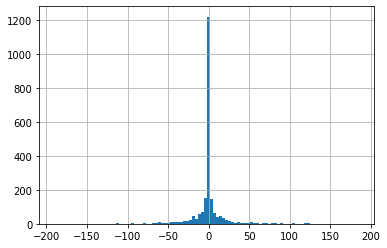

In [200]:
self.road_links['volume_diff'].hist(bins=100)